# Домашнее задание 3. Детекция объектов

Сыграем в квиддич? Или лучше в карты?

В этом дз вам предстоит написать практически с нуля архитектуру для детекции, а также воспользоваться готовым решением. На выбор даётся два датасета, отличаются они только картинками. Форматы, баллы - все одинаково.

Первый вариант это датасет по кадрам игры в квиддич из Гарри Поттера. Если вы забыли правила, то нажмите [сюда](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). Вы научитесь искать и выделять на фотографиях бладжеры, квоффл и снитч.

Второй вариант это датасет с игральными картами. Если вы забыли что такое карты, то нажмите [сюда](https://ru.wikipedia.org/wiki/%D0%98%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B). Вы научитесь искать и выделять на фотографиях несколько типов карт.

Оба варианта содержат около 300 картинок, данные хранятся в xml в формате PascalVOC. Есть малые отличия, но ничего страшного.


Если с самописным детектором совсем не получается, то можно после создания датасетов перейти к концу, где обучается готовый, с ним будет проще :)

# Notes

Дз проверялось на работоспособность в colab. Не гарантируется, что будет работать на чем-то другом, и точно не будет работать из коробки на Windows.

По вопросам формулировок (не ошибок торча!), в случае отсутствия ответа в общем чате (поиск по чату позволяет проверить), можно написать в него с тегом @markblumenau.

## Данные

Скачайте один из датасетов на свой вкус и начните работу с ним.
Разметка находится в xmls папке, картинки в images.

In [59]:
# Harry Potter -- uncomment
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip

# Cards -- uncomment
#!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip



!unzip -q data.zip

--2023-12-07 20:37:25--  https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/harry/data.zip [following]
--2023-12-07 20:37:25--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/harry/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17592727 (17M) [application/zip]
Saving to: ‘data.zip.1’

data.zip.1          100%[===================>]  16.78M  --.-KB/s    in 0.08s   

2023-12-07 20:37:25 (202 MB/s) - ‘data.zip.1’ saved [17592727/17592727]

replace data/class_dict? [y]es, [n]o, [A]ll

# Задача 1. 0.5 балла.

Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

In [60]:
import torch
from xml.etree import ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import torchvision
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm
from torch import nn
import shutil
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

Функции можно и нужно передать некий class_dict. Он есть и при инициализации датасета ниже. С его помощью можно название класса превратить в int. Далее подразумевается, что класс идёт как int.

In [81]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0]
    # read xml
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()
    # iterate over bboxes
    bboxes = []
    for member in treeroot.findall("object"):
        for elem in member.findall("bndbox"):
          xmin = int(elem.find('xmin').text)
          ymin = int(elem.find('ymin').text)
          xmax = int(elem.find('xmax').text)
          ymax = int(elem.find('ymax').text)
          cl = class_dict[str(member.find('name').text)]

          res =  [xmin, ymin, xmax, ymax, cl]
          bboxes.append(res)
    return bboxes

In [82]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):
        ### YOUR CODE HERE ###

        fname = self.filenames[idx]
        image = np.array(Image.open(fname))
        bboxes = get_xml_data(fname, self.root, self.class_dict)

        return self.transform(image=image, bboxes=bboxes)

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):
        ### YOUR CODE HERE ###

        return len(self.filenames)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [83]:

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [84]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

# Задача 2. 1 балл.

Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишите функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.

В датасете есть class_dict_inv, который позволит вам сделать обратное преобразование: int, содержащий класс, в строку с названием.


Полезные функции:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- легко создавать несколько изображений в одной pyplot figure
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- отображение графиков (не забудьте откатить нормализацию)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- для рисования прямоугольников и текста с аннотацией

In [85]:
import torchvision.transforms as transforms
import math
from matplotlib.patches import Rectangle


In [86]:
def visualize(images, bboxes):

    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(images):
            break

        inv_transform = transforms.Compose(
            [
                transforms.Normalize([-m/s for m, s in zip(mean, std)], [1/s for s in std])
            ]
        )
        img = inv_transform(images[i])
        img = img.permute(1, 2, 0)

        # Вот тут нужно выполнить permute (вспомните где у torch каналы, а где они у matplotlib)
        # И откатить нормализацию (просто обратное преобразование)
        # Имена и количества классов можно подтянуть из датасета через train_ds.class_dict_inv

        ax.imshow(img)
        for bbox in bboxes[i]:
            width = bbox[2] - bbox[0]
            height = bbox[3] - bbox[1]
            ax.add_patch(Rectangle((bbox[0], bbox[1]), width, height, edgecolor='red', facecolor='none'))
            ax.text(bbox[0], bbox[3], train_ds.class_dict_inv[bbox[-1]], color='red')

    fig.tight_layout()
    plt.show()

У вас должно получиться что-то похожее на изображения для датасета с масками:

![image](https://gcdnb.pbrd.co/images/n8BnhhfCgYnQ.png)

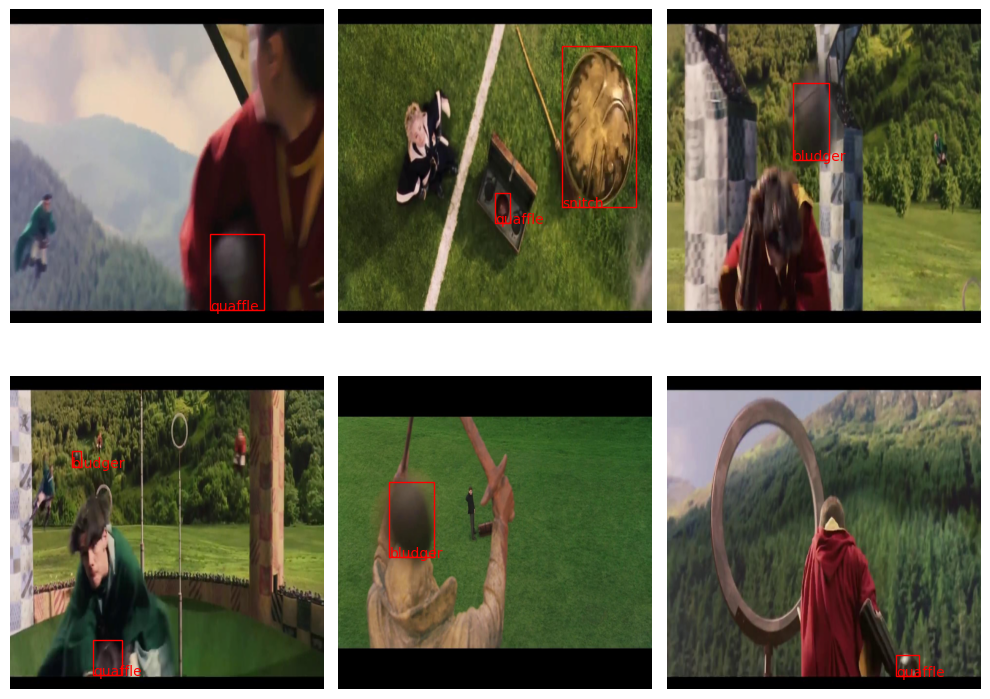

In [87]:
out = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out])

# Задача 3. 3 балла.
## YOLO-like детектор

Сейчас нам предстоить реализовать детектор, похожий на YOLO. Это один из самых простых детекторов с точки зрения реализации. YOLO описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Здесь мы его немного изменим и упростим. Будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16.

We convert lists of bounding boxes to the target downsampled grid. For this we

* compute centers of bounding boxes ($c_x, c_y$)
* change center coordinates (offset from the top left corner for each corresponding grid cell on a small grid)
* normalize box height and with to $[0, 1]$
* fill the target grid with values

## Задача 3.1. 1 балл.

Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).

Это функция должна принять на вход лист прямоугольников и сгенерировать тензор размера Bx16x16x6. Первая размерность - это количество примеров в батче. Далее идут две пространственные размерности, это сетка 16 на 16.

В каналах у нас будут записаны:
* Сдвиги центра bbox относительно начала клеточки (клеточка это "пиксель" на изображении 16 на 16 на выходе сети). Записаны эти сдвиги будут в клеточку, к которой относятся. 2 канала (X, Y)
* Нормализованные ширина и высота bbox. 2 канала (W, H)
* Confidence сетки. Им мы будем пользоваться, чтобы фильтровать уверенность сетки в наличии bbox в данной клетке. Таргет содержит 1 там, где bbox есть, и 0 иначе. 1 канал
* Класс детекции (тот самый int, полученный из строки с названием)

In [88]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))

    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )

        # Нормализуйте ширину и высоту, поделив на ширину и высоту исходного изображения
        x_cell =  downsample
        y_cell =  downsample
        w_box = (xmax - xmin) / 512
        h_box =  (ymax - ymin) / 512

        # Посчитайте координаты центра и сдвиги
        cx =  (xmax + xmin) / 2
        cy =  (ymax + ymin) / 2
        cx_idx = (cx / downsample).to(torch.long)
        cy_idx = (cy / downsample).to(torch.long)

        cx_box = (cx - cx_idx * downsample) / downsample
        cy_box = (cy - cy_idx * downsample) / downsample

        target[i, :, cy_idx, cx_idx] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )


    return {"image": imgs, "target": target}

Ниже вы можете увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

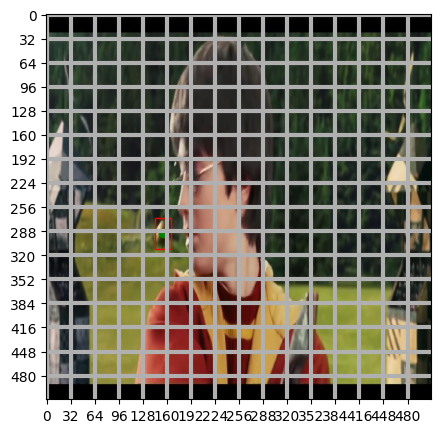

In [89]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

## Задача 3.2. 0.5 балла.

Выход нашей сетки будет несколько больше, чем Bx16x16x6. Почему?

Мы решаем задачу, где классов больше одного. Вспомним прошлое дз: target был одним числом, но выход сетки содержал длинный-длинный вектор, из которого мы получали вероятность принадлежности к тому или иному классу. Здесь то же самое, но как бы в двумерии: у каждой клеточки из этих 16*16 будет свой вектор длины C, который мы будем использовать для определения класса.

Реализуйте обратное относительно collate_fn преобразования, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function вы должны получить изначальный набор прямоугольников с корректными размерами и координатами, а также классами. Применив к выходу нейросети мы тоже должны получить набор прямоугольников и тоже с корректными классами.

То есть, нужно проделать операции из collate_fn в обратную сторону, но учесть, что у неройнки выход будет чуть длиннее, и там мы должны брать argmax для определения класса.

Hint: в target classes идут в конце. В нейронке они тоже будут в конце, но их будет больше 1. Можно проверять число каналов пришедшего объекта, если оно 6, то перед нами target и надо брать значение, которое записано в клеточке. Иначе (каналов больше 6) перед нами выход нейронки, и надо брать самый вероятный из них.

In [106]:
def decode_prediction(pred, upsample=32, threshold=0.7):
    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample
    bboxes = []
    for i in range(b):
        for j in range(h):
            for k in range(w):
                vec = pred[i, :, j, k]
                if vec[4] >= threshold:
                    w_box = vec[2] * img_w
                    h_box = vec[3] * img_h

                    cx_box = vec[0] * upsample
                    cy_box = vec[1] * upsample

                    cx = k * upsample + cx_box
                    cy = j * upsample + cy_box

                    xmin = cx - w_box / 2
                    ymin = cy - h_box / 2
                    xmax = cx + w_box / 2
                    ymax = cy + h_box / 2

                    cl= torch.argmax(vec[5:8]).item()
                    bbox = (xmin, ymin, xmax, ymax, cl)
                    bboxes.append(bbox)
    return bboxes


## Задача 3.3. 1 балл.
Реализуйте модель. Первым делом примените первые 4 блока (до layer4 включительно) ResNet50. Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшайте количество каналов до 5+C, а размер изображения до 16 на 16. Например, 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в вашем датасете. Размер ядра при этом 3, паддинг 1. Но вариантов много, попробуйте разные! **Последним слоем обязательно должна быть свертка.** Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.

Если будете фантазировать, то для получения правильного размера изображения после сети не стесняйтесь применять слои с фильтрами больше 3.

In [91]:
C =  3

class Detector(nn.Module):
    def __init__(self):
        super().__init__()
        model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.model = nn.Sequential(*(list(model.children())[:-2]))
        self.fc1 = nn.Sequential(nn.Conv2d(2048, 512, 3, padding=1),
                                 nn.BatchNorm2d(512),
                                 nn.ReLU())
        self.fc2 = nn.Sequential(nn.Conv2d(512, 128, 3, padding=1),
                                 nn.BatchNorm2d(128),
                                 nn.ReLU())
        self.fc3 = nn.Sequential(nn.Conv2d(128, 32, 3, padding=1),
                                 nn.BatchNorm2d(32),
                                 nn.ReLU())
        self.fc4 = nn.Sequential(nn.Conv2d(32, 8, 3, padding=1),
                                 nn.BatchNorm2d(8),
                                 nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out

## Задача 3.4. 0.5 балла.

Реализуйте функцию потерь.

Для этого:
* Сделайте маску, которая будет говорить о положении детектируемых объектов. Её нужно использовать с помощью masked_select (см. доки PyTorch)
* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)
    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект
    - box_loss - MSE от корней ширины и высоты bbox там, где есть детектируемый объект
    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу
    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)


* Ниже есть assert. Если вы экспериментируете с лоссом, он не будет проходить, не обращайте на него внимание. Если будете делать описанное выше, то учтите reduction. Бинарная кросс-энтропия вызывается через BCELoss. Параметр C используется для задачи числа классов. assert написан для 3 классов, в задаче с картами их 6. Подумайте как зависит индексация от параметра C и используйте его.

In [92]:
def special_loss(pred, target, check, C=3):

    mask = target[:, 4, :, :].ge(0.01)
    mse_loss = nn.MSELoss(reduction='sum')
    cr_loss = nn.CrossEntropyLoss(reduction='sum')
    bce_loss = nn.BCELoss(reduction='sum')

    x_loss = mse_loss(torch.masked_select(pred[:, 0, :, :], mask), torch.masked_select(target[:, 0, :, :], mask))
    y_loss = mse_loss(torch.masked_select(pred[:, 1, :, :], mask), torch.masked_select(target[:, 1, :, :], mask))
    localization_loss = x_loss + y_loss

    w_loss = mse_loss(torch.masked_select(torch.sqrt(torch.abs(pred[:, 2, :, :])), mask), torch.masked_select(torch.sqrt(target[:, 2, :, :]), mask))
    h_loss = mse_loss(torch.masked_select(torch.sqrt(torch.abs(pred[:, 3, :, :])), mask), torch.masked_select(torch.sqrt(target[:, 3, :, :]), mask))
    box_loss = w_loss + h_loss


    class_mask = mask.unsqueeze(1).expand(-1, C, -1, -1)
    class_pred = pred[:, 5:(5+C), :, :]
    class_pred = class_pred[class_mask].view(-1, C)
    class_true = target[:, 5, :, :][mask].long()
    classification_loss = cr_loss(class_pred, class_true)

    loss_d = bce_loss(torch.masked_select(pred[:, 4, :, :], mask), torch.masked_select(target[:, 4, :, :], mask))
    loss_non_d = bce_loss(torch.masked_select(pred[:, 4, :, :], ~mask), torch.masked_select(target[:, 4, :, :], ~mask))
    confidence_loss = loss_d + 0.1 * loss_non_d

    if not check:
        return localization_loss + box_loss + classification_loss + confidence_loss

    else:
        return localization_loss, box_loss, classification_loss, confidence_loss

In [93]:
# localization box classification confidence - возвращаются в таком порядке, можно сравнить
assert special_loss(torch.zeros((10, 8, 16, 16)), torch.ones((10, 8, 16, 16)), check=True, C=3) == (torch.tensor(5120.), torch.tensor(5120.), torch.tensor(2812.4465), torch.tensor(256000.))

# Задача 4. 2 балла.

Обучите вашу модель (написав цикл обучения), и покажите что она работает (скорее всего, объекты найдутся на 1-2 картинках).

In [94]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

In [95]:
torch.cuda.is_available()

True

In [96]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(21)
EPOCHS =  20
model = Detector().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    for batch in pbar:
        x, y = batch['image'], batch['target']
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = special_loss(y_pred, y, check=False, C=3)
        loss.backward()
        opt.step()
        opt.zero_grad()
        epoch_losses.append(loss.detach().item())

    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 0 done; Train loss 207.111;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 1 done; Train loss 183.008;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 2 done; Train loss 175.229;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 3 done; Train loss 169.202;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 4 done; Train loss 164.444;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 5 done; Train loss 160.080;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 6 done; Train loss 155.925;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 7 done; Train loss 151.874;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 8 done; Train loss 148.860;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 9 done; Train loss 145.647;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 10 done; Train loss 142.218;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 11 done; Train loss 139.016;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 12 done; Train loss 136.421;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 13 done; Train loss 133.985;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 14 done; Train loss 131.307;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 15 done; Train loss 128.773;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 16 done; Train loss 126.344;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 17 done; Train loss 123.803;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 18 done; Train loss 121.744;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 19 done; Train loss 119.010;


Запустим обученный детектор на тестовых изображениях:

In [97]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [98]:
# Нужно сделать предсказание и переложить результат на cpu

with torch.no_grad():
  preds = model(batch['image'].to(device)).cpu()

In [99]:
def visualize(images, bboxes):

    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(images):
            break

        inv_transform = transforms.Compose(
            [
                transforms.Normalize([-m/s for m, s in zip(mean, std)], [1/s for s in std])
            ]
        )
        img = inv_transform(images[i])
        img = img.permute(1, 2, 0).cpu().numpy()
        # Вот тут нужно выполнить permute (вспомните где у torch каналы, а где они у matplotlib)
        # И откатить нормализацию (просто обратное преобразование)
        # Имена и количества классов можно подтянуть из датасета через train_ds.class_dict_inv
        ax.imshow(img)
        bbox = bboxes[i]
        xmin, ymin, xmax, ymax = bbox[:-1]
        xmin, ymin, xmax, ymax = xmin.cpu().item(), ymin.cpu().item(), xmax.cpu().item(), ymax.cpu().item()
        width = xmax - xmin
        height = ymax - ymin
        key = bbox[-1]
        label = train_ds.class_dict_inv[key]
        ax.add_patch(Rectangle((xmin, ymin), width, height, edgecolor='red', facecolor='none'))
        ax.text(xmin, ymax, label, color='red')
    fig.tight_layout()
    plt.show()

При разных threshold есть разные попадания:

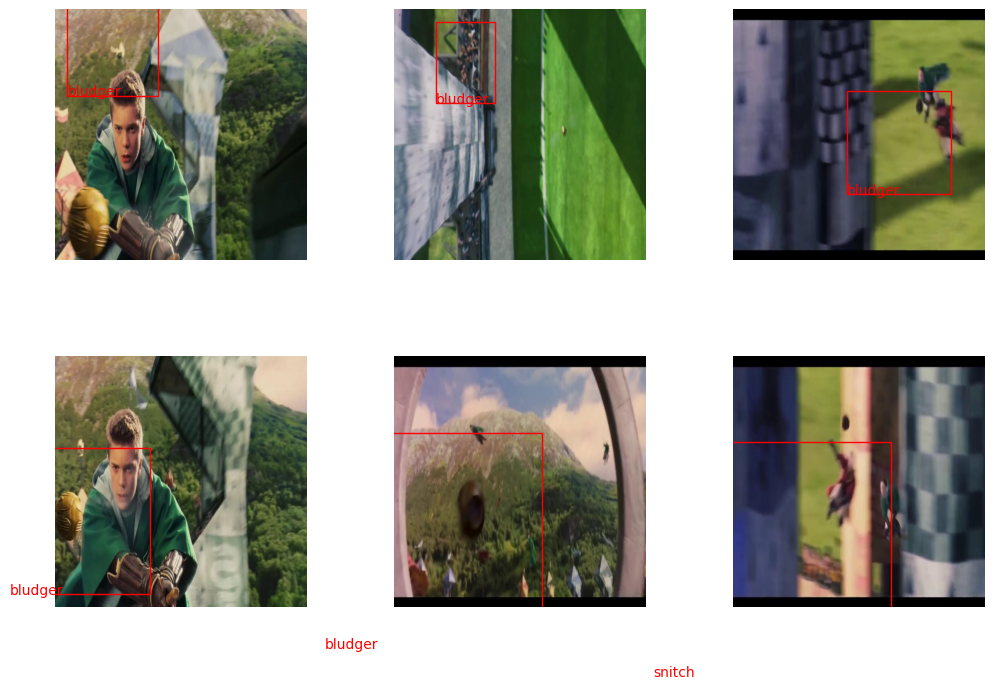

In [119]:
# Сделайте визуализацию. Поиграйтесь с threshold, скорее всего нужно понизить до ~0.1

visualize(batch['image'], decode_prediction(preds, upsample=32, threshold=0.4))

Результат сильно так себе, да? Есть множество вариантов улучшений, самый простой из которых это приделать к выходу [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.). Если хочется, можно почитать про YOLO v1 [тут](https://arxiv.org/abs/1506.02640).

# Задача 5. 3.5 балла.

Займёмся более простыми вещами. Возьмем готовую архитектуру, обучим её на наших данных и посмотрим.

Для этого будем использовать YOLO v8 от ultralytics.

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 659.4/659.4 kB 5.5 MB/s eta 0:00:00


## Задача 5.1. 1.5 балла.

Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Да-да, классика перекладывания JSON. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).

Если коротко:
* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия
* Есть папочки train valid (их поможем вам собрать), в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [ ]:
# Делаем папочки
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Реализуйте функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO v8. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.

In [ ]:
def annotation2txt(bboxes, w_im, h_im):
    yolo_annotations = []
    for bbox in bboxes:
        # Получаем координаты и класс объекта
        x_min, y_min, x_max, y_max, class_id = bbox

        # Переводим координаты в относительные значения
        x_center = ((x_min + x_max) / 2) / w_im
        y_center = ((y_min + y_max) / 2) / h_im
        width = (x_max - x_min) / w_im
        height = (y_max - y_min) / h_im

        # Формируем строку аннотации для YOLO
        yolo_annotation = f"{class_id} {x_center} {y_center} {width} {height}"
        yolo_annotations.append(yolo_annotation)

    return yolo_annotations

In [ ]:
# Копируем картиночки по папочкам и создаем txt файлики

for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )

    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [ ]:
# Собираем YAML

nc =  3
names = list(train_ds.class_dict.keys())

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

## Задание 5.2. 1.5 балла.

Обучите модель YOLO v8 самого маленького размера. Библиотека максимально friendly, от вас требуется написать две строчки. Модель нужно взять необученную!

Подсказка: подумайте зачем вам data.yaml и что такое yolov8n.yaml (не стесняйтесь гуглить)

In [ ]:
import ultralytics
from ultralytics import YOLO

model = YOLO('yolov8n.yaml')
model.train(data='data.yaml', epochs=100)



                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

100%|██████████| 6.23M/6.23M [00:00<00:00, 77.2MB/s]


AMP: checks passed ✅


train: Scanning /content/train/labels.cache... 254 images, 0 backgrounds, 0 corrupt: 100%|██████████| 254/254 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels.cache... 29 images, 0 backgrounds, 0 corrupt: 100%|██████████| 29/29 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.97G      4.563      9.194      4.241         30        640: 100%|██████████| 16/16 [00:12<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      5.81G      4.958      8.703      4.115         37        640: 100%|██████████| 16/16 [00:04<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      5.81G      4.072      7.808      3.921         31        640: 100%|██████████| 16/16 [00:06<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.81G      3.835      6.728      3.654         38        640: 100%|██████████| 16/16 [00:04<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      5.81G      3.493      6.137      3.261         27        640: 100%|██████████| 16/16 [00:05<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      5.81G      3.212      6.043      3.029         25        640: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      5.81G      2.986      5.788      2.868         26        640: 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      5.81G        2.9      5.008      2.703         39        640: 100%|██████████| 16/16 [00:05<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.81G      2.692      4.696      2.554         28        640: 100%|██████████| 16/16 [00:04<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      5.81G      2.676      4.468       2.38         34        640: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      5.81G      2.747      4.283      2.362         23        640: 100%|██████████| 16/16 [00:04<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.81G      2.516      3.884      2.205         32        640: 100%|██████████| 16/16 [00:05<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.81G      2.458      3.741      2.178         21        640: 100%|██████████| 16/16 [00:04<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      5.81G       2.49       3.48      2.219         22        640: 100%|██████████| 16/16 [00:07<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.81G      2.372      3.445      2.072         35        640: 100%|██████████| 16/16 [00:05<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all         29         35   0.000124     0.0123   7.42e-05   7.42e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.81G      2.398      3.515      1.996         22        640: 100%|██████████| 16/16 [00:13<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all         29         35   0.000124     0.0123   7.42e-05   7.42e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      5.81G      2.253      3.091      1.953         22        640: 100%|██████████| 16/16 [00:04<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         29         35   0.000124     0.0123   7.42e-05   7.42e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.81G      2.265      3.166      1.945         39        640: 100%|██████████| 16/16 [00:05<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all         29         35   0.000124     0.0123   7.42e-05   7.42e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.81G      2.325      2.937       1.99         31        640: 100%|██████████| 16/16 [00:04<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

                   all         29         35   0.000143     0.0123   7.78e-05   1.56e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.81G      2.146      2.859      1.871         26        640: 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all         29         35   0.000143     0.0123   7.78e-05   1.56e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.81G      2.099      2.857      1.798         30        640: 100%|██████████| 16/16 [00:04<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

                   all         29         35   0.000143     0.0123   7.78e-05   1.56e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.81G      2.038      2.785      1.801         30        640: 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         29         35   0.000143     0.0123   7.78e-05   1.56e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.81G      2.107      2.584      1.813         27        640: 100%|██████████| 16/16 [00:04<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all         29         35   0.000143     0.0123   7.78e-05   1.56e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.81G      2.077      2.595      1.777         23        640: 100%|██████████| 16/16 [00:04<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

                   all         29         35   0.000143     0.0123   7.78e-05   1.56e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.81G      2.016      2.416      1.745         26        640: 100%|██████████| 16/16 [00:04<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

                   all         29         35   0.000143     0.0123   7.78e-05   1.56e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.81G       2.02      2.361      1.723         32        640: 100%|██████████| 16/16 [00:04<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all         29         35   0.000143     0.0123   7.78e-05   1.56e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.81G       2.01      2.336      1.729         28        640: 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         29         35   0.000143     0.0123   7.78e-05   1.56e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.81G      2.075      2.446      1.793         31        640: 100%|██████████| 16/16 [00:04<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

                   all         29         35   0.000143     0.0123   7.78e-05   1.56e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.81G      1.895      2.236      1.657         33        640: 100%|██████████| 16/16 [00:06<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all         29         35   0.000143     0.0123   7.78e-05   1.56e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.81G      1.987      2.334      1.683         41        640: 100%|██████████| 16/16 [00:05<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         29         35   0.000143     0.0123   7.78e-05   1.56e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.81G      1.908      2.329      1.642         23        640: 100%|██████████| 16/16 [00:05<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all         29         35   0.000143     0.0123   7.78e-05   1.56e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.81G      1.949      2.222      1.653         28        640: 100%|██████████| 16/16 [00:04<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]

                   all         29         35   0.000143     0.0123   7.78e-05   1.56e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.81G      1.838      2.238      1.621         32        640: 100%|██████████| 16/16 [00:04<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         29         35   0.000143     0.0123   7.78e-05   1.56e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.81G      1.826      2.147      1.629         34        640: 100%|██████████| 16/16 [00:05<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

                   all         29         35   0.000143     0.0123   7.78e-05   1.56e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.81G      1.821      2.137       1.59         36        640: 100%|██████████| 16/16 [00:04<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all         29         35   0.000143     0.0123   7.78e-05   1.56e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.81G      1.799      2.043      1.575         31        640: 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

                   all         29         35   0.000143     0.0123   7.78e-05   1.56e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.81G       1.81      2.069      1.541         27        640: 100%|██████████| 16/16 [00:04<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

                   all         29         35   0.000143     0.0123   7.78e-05   1.56e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.81G      1.772      1.953      1.493         26        640: 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

                   all         29         35   0.000143     0.0123   7.78e-05   1.56e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.81G      1.827      2.032      1.555         23        640: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]

                   all         29         35   0.000143     0.0123   7.78e-05   1.56e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.81G      1.784      1.977      1.526         22        640: 100%|██████████| 16/16 [00:05<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all         29         35   0.000143     0.0123   7.78e-05   1.56e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.81G      1.772      1.927      1.526         34        640: 100%|██████████| 16/16 [00:04<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

                   all         29         35   0.000143     0.0123   7.78e-05   1.56e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.81G      1.685      1.827      1.498         27        640: 100%|██████████| 16/16 [00:04<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

                   all         29         35   0.000143     0.0123   7.78e-05   1.56e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.81G      1.745      1.809      1.528         30        640: 100%|██████████| 16/16 [00:05<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]

                   all         29         35   0.000143     0.0123   7.78e-05   1.56e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.81G      1.786      1.892      1.555         29        640: 100%|██████████| 16/16 [00:04<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

                   all         29         35   0.000143     0.0123   7.78e-05   1.56e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      5.81G      1.638       1.77       1.44         19        640: 100%|██████████| 16/16 [00:07<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

                   all         29         35   0.000143     0.0123   7.78e-05   1.56e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.82G      1.724      1.849      1.541         22        640: 100%|██████████| 16/16 [00:04<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         29         35   0.000143     0.0123   7.78e-05   1.56e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.81G      1.675      1.716      1.478         32        640: 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all         29         35   0.000143     0.0123   7.78e-05   1.56e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      5.81G      1.679      1.746      1.479         37        640: 100%|██████████| 16/16 [00:04<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.81G      1.606      1.617       1.43         32        640: 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      5.81G      1.635      1.669      1.404         32        640: 100%|██████████| 16/16 [00:04<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.81G      1.581      1.631      1.413         33        640: 100%|██████████| 16/16 [00:05<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.81G      1.641      1.669      1.403         23        640: 100%|██████████| 16/16 [00:04<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      5.81G      1.625      1.605      1.428         42        640: 100%|██████████| 16/16 [00:04<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.81G      1.607      1.553      1.411         28        640: 100%|██████████| 16/16 [00:08<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.81G      1.591      1.597       1.46         26        640: 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      5.81G      1.581      1.521      1.379         13        640: 100%|██████████| 16/16 [00:04<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.81G      1.595      1.542      1.408         24        640: 100%|██████████| 16/16 [00:04<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      5.81G      1.561      1.496      1.371         26        640: 100%|██████████| 16/16 [00:05<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      5.81G      1.548      1.485       1.39         26        640: 100%|██████████| 16/16 [00:04<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.81G       1.49      1.485      1.327         32        640: 100%|██████████| 16/16 [00:07<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      5.81G      1.488      1.375      1.311         32        640: 100%|██████████| 16/16 [00:08<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      5.81G      1.538      1.471      1.365         26        640: 100%|██████████| 16/16 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      5.81G      1.505      1.421       1.37         33        640: 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.81G      1.563       1.42      1.369         28        640: 100%|██████████| 16/16 [00:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      5.81G      1.518      1.397      1.363         22        640: 100%|██████████| 16/16 [00:04<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      5.81G      1.435      1.372      1.336         24        640: 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.81G      1.475      1.386      1.352         32        640: 100%|██████████| 16/16 [00:04<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      5.81G      1.456      1.365      1.299         26        640: 100%|██████████| 16/16 [00:08<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      5.81G       1.49      1.422      1.341         30        640: 100%|██████████| 16/16 [00:05<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.81G      1.431      1.342      1.371         26        640: 100%|██████████| 16/16 [00:07<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      5.81G      1.412      1.333      1.301         32        640: 100%|██████████| 16/16 [00:05<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      5.81G       1.44      1.263      1.291         34        640: 100%|██████████| 16/16 [00:07<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.81G       1.44      1.288      1.276         27        640: 100%|██████████| 16/16 [00:04<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      5.81G      1.455      1.311      1.273         29        640: 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.81G       1.37      1.259      1.256         33        640: 100%|██████████| 16/16 [00:04<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      5.81G      1.409       1.27      1.259         23        640: 100%|██████████| 16/16 [00:05<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      5.81G      1.375      1.201      1.271         32        640: 100%|██████████| 16/16 [00:04<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      5.81G      1.407      1.192      1.282         36        640: 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      5.81G      1.383      1.209      1.323         21        640: 100%|██████████| 16/16 [00:04<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.81G      1.435      1.246      1.322         30        640: 100%|██████████| 16/16 [00:04<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      5.81G      1.349       1.21       1.29         26        640: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      5.81G      1.313      1.151      1.244         39        640: 100%|██████████| 16/16 [00:04<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.81G      1.376      1.217      1.292         28        640: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.81G      1.361      1.152      1.271         29        640: 100%|██████████| 16/16 [00:04<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.81G      1.327      1.147      1.235         26        640: 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.81G      1.317      1.124      1.279         24        640: 100%|██████████| 16/16 [00:04<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      5.81G      1.324      1.165      1.285         28        640: 100%|██████████| 16/16 [00:04<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.81G      1.311      1.154      1.278         26        640: 100%|██████████| 16/16 [00:04<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.81G      1.321      1.143      1.254         23        640: 100%|██████████| 16/16 [00:04<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.81G      1.324      1.127      1.228         32        640: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.81G      1.345      1.285      1.279         18        640: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.82G      1.287      1.158      1.229         14        640: 100%|██████████| 16/16 [00:05<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.82G      1.334       1.23      1.255         15        640: 100%|██████████| 16/16 [00:04<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.81G      1.261       1.12      1.227         17        640: 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      5.82G      1.219      1.083      1.225         14        640: 100%|██████████| 16/16 [00:04<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.82G      1.276      1.096      1.203         17        640: 100%|██████████| 16/16 [00:05<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.82G      1.225      1.101      1.212         15        640: 100%|██████████| 16/16 [00:04<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.81G      1.269      1.099      1.234         14        640: 100%|██████████| 16/16 [00:04<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.81G      1.225      1.034      1.195         18        640: 100%|██████████| 16/16 [00:05<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      5.82G      1.214      1.019      1.188         15        640: 100%|██████████| 16/16 [00:04<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05



100 epochs completed in 0.202 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.0.223 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         29         35   0.000482     0.0123   0.000268   7.73e-05
                snitch         29          6          0          0          0          0
               quaffle         29         27    0.00145      0.037   0.000805   0.000232
               bludger         29          2          0          0          0          0


Speed: 0.1ms preprocess, 1.8ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7dd9ba3b94b0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

## Задание 5.3. 0.5 балла.

Как-нибудь отрисуйте предсказания на валидационной выборке (хотя бы части из 5-10 картинок).

Здесь можно использовать костыли с параметром save=True у predict, потом прочитать их чем-нибудь, отрисовать матплотлибом. Есть варианты и получше. Дефолтный show будет пытаться показывать через opencv imshow, он в коллабе работать не будет.

In [ ]:
for i in [26, 33, 56, 63, 70]:
    img_path = f'/content/valid/images/{i}.jpg'
    results = model.predict(img_path, save=True, project='runs/detect', name='custom_prediction')


image 1/1 /content/valid/images/26.jpg: 320x640 1 quaffle, 123.9ms
Speed: 2.0ms preprocess, 123.9ms inference, 2.2ms postprocess per image at shape (1, 3, 320, 640)
Results saved to runs/detect/custom_prediction

image 1/1 /content/valid/images/33.jpg: 320x640 1 quaffle, 7.7ms
Speed: 1.3ms preprocess, 7.7ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 640)
Results saved to runs/detect/custom_prediction2

image 1/1 /content/valid/images/56.jpg: 320x640 (no detections), 7.5ms
Speed: 1.2ms preprocess, 7.5ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)
Results saved to runs/detect/custom_prediction3

image 1/1 /content/valid/images/63.jpg: 320x640 1 snitch, 7.7ms
Speed: 1.3ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 320, 640)
Results saved to runs/detect/custom_prediction4

image 1/1 /content/valid/images/70.jpg: 320x640 1 quaffle, 7.7ms
Speed: 1.3ms preprocess, 7.7ms inference, 1.9ms postprocess per image at shape (1, 3, 

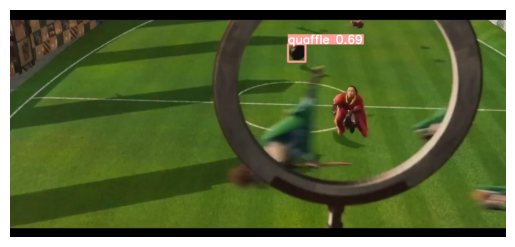

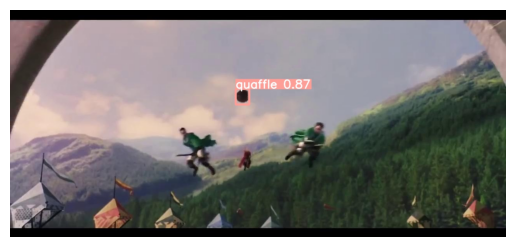

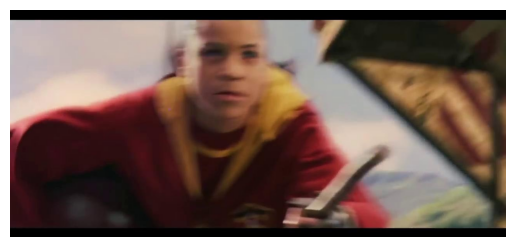

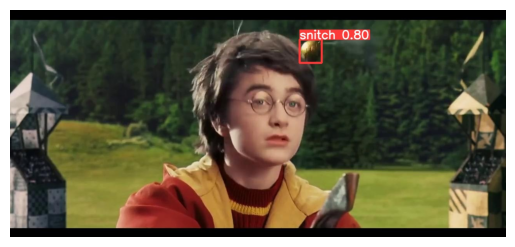

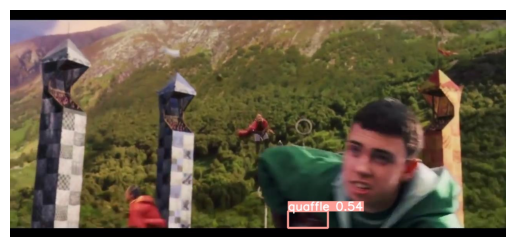

In [ ]:
saved_images_dir = 'runs/detect/custom_prediction'

j = 1
for i in [26, 33, 56, 63, 70]:
    if j == 1:
      img = Image.open(f'runs/detect/custom_prediction/{i}.jpg')
    else:
      img = Image.open(f'runs/detect/custom_prediction{j}/{i}.jpg')
    j += 1
    plt.imshow(img)
    plt.axis('off')
    plt.show()


In [ ]:
def decode_prediction(pred, upsample=32, threshold=0.7):
    b, c, h, w = pred.shape
    # b - batch_size, c - channels, h - height, w - width
    img_w, img_h = w * upsample, h * upsample
    bboxes = []
    if c == 8:
        transformed = torch.argmax(pred[:, 5:8, :, :], dim=1).unsqueeze(1)  # Add a channel dimension
        pred = torch.cat([pred[:, 0:5, :, :], transformed], dim=1)
    for i in range(16):
      for j in range(16):
        vec = pred[:, 4, i, j]
        if vec[4] >= threshold:
          w = vec[2] * 512
          h = vec[3] * 512
          lower_left = i * upsample
          upper_right = j * upsample
          cx = lower_left + vec[0] * upsample
          cy = upper_right - vec[1] * upsample
          cls = vec[-1]
          bbox = (lower_left, upper_right - h, lower_left + w, upper_right, cls)
          bboxes.append(bbox)
    return bboxes